### Load modules

In [1]:
%load_ext autoreload
%autoreload 2

# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random as rnd
import time

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from priorCVAE.models.data import *

# import VAE architecture
from priorCVAE.models.cvae import *

# import loss functions
from priorCVAE.models.losses import *

from priorCVAE.models.priors import exp_sq_kernel

from priorCVAE.diagnostics import *

# Test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

# test kl_divergence
#x1 = jnp.array([1.1,2,3])
#kl = kl_divergence(x1, x1)
#kl

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.12
Flax version:     0.6.10
Optax version:    0.1.5
Pythorch version: 3.10.11


In [2]:
import scipy.stats as stats
from collections import defaultdict

### Setup arguments

In [3]:
args = {"seed": 0,
        
        # data
        "num_samples": 10000,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
        "vae_var": 1, 

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples_mcmc": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data


In [4]:


train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=42, ls=0.2)  
val_set   = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=43, ls=0.2)  
test_set  = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=44, ls=0.2)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            #train=[True, False, False],
                                                            train=[True, True, True],
                                                            batch_size=args["batch_size"])

train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

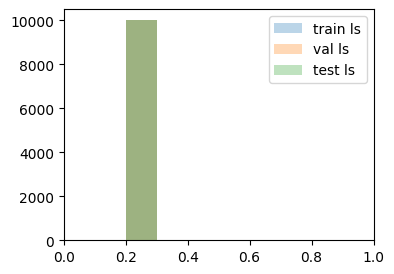

In [5]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()


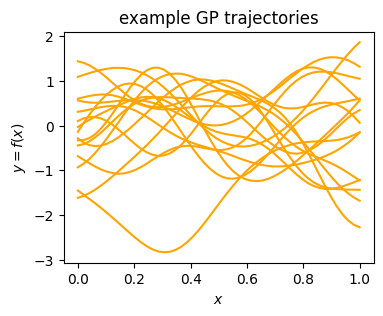

In [6]:
# check: what trajectories are we generating?

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

In [7]:
gp_realizations = train_set.y
def means_MSE(x):
    return np.square(x.mean(axis=0)).sum()/x.shape[1]


### VAE Model

In [8]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
conditional = args["conditional"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]
vae_var     = args["vae_var"]

### Training loop

In [9]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y, z_rng) 
        rcl_loss = rcl(y_hat, y, vae_var).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params, z_rng)
    return state.apply_gradients(grads=grads), loss_fn(state.params, z_rng)

In [10]:
@jax.jit
def eval(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y, z_rng) 
        rcl_loss = rcl(y_hat, y, vae_var).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params, z_rng)

[    1] training loss: 1741.139, test loss: 1697.084
[   11] training loss: 799.845, test loss: 832.613
[   21] training loss: 756.288, test loss: 771.899
[   31] training loss: 749.392, test loss: 741.702
[   41] training loss: 721.216, test loss: 745.996
[   51] training loss: 776.670, test loss: 736.489
[   61] training loss: 757.923, test loss: 768.991
[   71] training loss: 770.839, test loss: 761.506
[   81] training loss: 779.364, test loss: 754.398
[   91] training loss: 739.722, test loss: 760.762
[  101] training loss: 788.191, test loss: 725.285
[  111] training loss: 792.922, test loss: 734.058
[  121] training loss: 745.916, test loss: 735.984
[  131] training loss: 760.027, test loss: 770.271
[  141] training loss: 747.281, test loss: 725.932
[  151] training loss: 740.594, test loss: 704.185
[  161] training loss: 766.927, test loss: 778.270
[  171] training loss: 771.054, test loss: 735.936
[  181] training loss: 769.032, test loss: 761.739
[  191] training loss: 721.99

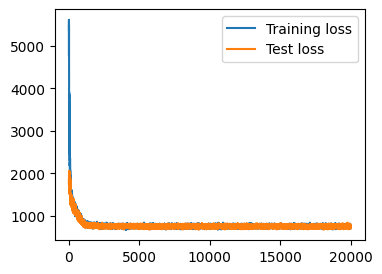

In [11]:
# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
rng, z_key, eval_key = random.split(key, 3)

batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(rng, y, key)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

_loss_train = []
_loss_test = []

t_start = time.time()



for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        z_key, key = random.split(z_key)
        state, loss_train = train_step(state, batch_train, key)
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):

        eval_key, key = random.split(eval_key)
        loss_test = eval(state, batch_test, key)
        _loss_test.append(loss_test)

    if epoch % 10 == 0:   
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_samples // batch_size

plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()

#### What have we learnt?

In [12]:
# Get trained decoder params
decoder_params = state.params['decoder']

In [13]:
rng, z_rng = random.split(rng, 2)

# latents as input
z = random.normal(z_rng, (10000, latent_dim))

# create decoder
decoder = Decoder(hidden_dim, out_dim)

# Apply decoder with parameters on the data
out = decoder.apply({'params': decoder_params}, z)   

# print(f'VAE: {means_MSE(out)}')
# print(f'GP: {means_MSE(gp_realizations)}')
# out.shape

In [14]:
vae_realizations = out
grid = np.linspace(0, 1, 50) 

In [15]:
mean_bootstrap_confidence_interval(vae_realizations)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True]),
 38)

In [16]:
def evaluate_means_by_percentiles(realizations):
    """
    Checks whether zero lies between the 5th- and 95th-percentile of the distributions of means of sample realizations.

    Args:
        realizations: Array of shape (num_realizations, grid_size)
    Returns:
        zero_in_interval: True if lies between 5th and 95th percentile of the means. False otherwise.

    """
#     means = realizations.mean(axis=0)
    means = realizations
    percentile_5 = np.percentile(means, 5)
    percentile_95 = np.percentile(means, 95)

    zero_in_interval = (percentile_5 <= 0) & (0 <= percentile_95)
    print(percentile_5, percentile_95)
    print(means)
    return zero_in_interval
evaluate_means_by_percentiles(res.bootstrap_distribution)

NameError: name 'res' is not defined

In [ ]:
evaluate_means_by_percentiles(gp_realizations)

In [ ]:
vae_means = vae_realizations.mean(axis=0)

import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt

ecdf = sm.distributions.ECDF(vae_realizations[20,:])

x = np.linspace(min(vae_realizations[30,:]), max(vae_realizations[30,:]))
y = ecdf(x)
plt.step(x, y)
plt.show()

In [ ]:
def evaluate_means_by_confidence_intervals(realizations):
    """
    Returns the number of points at which zero lies within the 95% confidence interval of the mean of the realizations at each point.

    Args:
        realizations: Array of shape (num_realizations, grid_size)
    Returns:
        num_valid: Number of means where zero lies between the 95% confidence interval.
    """
    means = np.mean(realizations, axis=0)
    sem = stats.sem(realizations, axis=0)

    ci_lower, ci_upper = stats.t.interval(
        confidence=0.95,
        df=realizations.shape[0]-1,
        loc=means,
        scale=sem,
    )

    zero_in_interval = (ci_lower <= 0) & (0 <= ci_upper)
    num_valid = np.where(zero_in_interval)[0].shape[0]
    
    print(np.where(zero_in_interval))
    print(f"Zero is in the 95% confidence interval at {num_valid} of {realizations.shape[1]} points.")
    
    return num_valid
    
evaluate_means_by_confidence_intervals(vae_realizations)

In [ ]:
def compute_empirical_covariance(realizations):

    covariance = np.cov(np.transpose(realizations))

    return covariance

In [ ]:
def evaluate_stationarity(realizations, lengthscale, grid, kernel_variance=1.0):

    covariance = compute_empirical_covariance(realizations)

    K = exp_sq_kernel(grid, grid, kernel_variance, lengthscale)

    dist_to_cov = defaultdict(list)
    for i in range(grid.shape[0]):
        for j in range(i,grid.shape[0]):
            dist_to_cov[abs(j-i)].append(covariance[i][j])

    valid = []
    for i in range(0,50):
        dist_covariances = dist_to_cov[i]

        percentile_5 = np.percentile(dist_covariances, 5)
        percentile_95 = np.percentile(dist_covariances, 95)
        
        true_covariance = K[0][i]
        zero_in_interval = (percentile_5 <= true_covariance) & (true_covariance <= percentile_95)
        valid.append(zero_in_interval)

    print(f"Number of distances that failed: {np.where(np.logical_not(valid))[0].shape[0]}")
    print(f"Number of distances that passed: {np.where(valid)[0].shape[0]}")

evaluate_stationarity(vae_realizations, lengthscale=0.2, grid=grid, kernel_variance=1.0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


n = 50

dist_to_cov = defaultdict(list)
vae_covariance = compute_empirical_covariance(vae_realizations)
for i in range(n):
    for j in range(i,n):
        dist_to_cov[abs(j-i)].append(vae_covariance[i][j])

In [ ]:
K = exp_sq_kernel(grid, grid, 1.0, args['true_ls'])

valid = []
for i in range(0,50):
    dist_covariances = dist_to_cov[i]

    percentile_5 = np.percentile(dist_covariances, 5)
    percentile_95 = np.percentile(dist_covariances, 95)
    
    true_covariance = K[0][i]
    zero_in_interval = (percentile_5 <= true_covariance) & (true_covariance <= percentile_95)
    valid.append(zero_in_interval)

print(f"Number of distances that failed: {np.where(np.logical_not(valid))[0].shape[0]}")
print(f"Number of distances that passed: {np.where(valid)[0].shape[0]}")

In [ ]:
vae_realizations.shape

In [ ]:
import matplotlib.pyplot as plt


for distance, covariances in dist_to_cov.items():
    # Repeat the current distance for as many times as there are covariances
    distances = [distance/50] * len(covariances)
    plt.scatter(distances, covariances, alpha=0.5)
    
plt.xlabel('Distance')
plt.ylabel('Covariance')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], vae_realizations[i,:])
    
ax.plot(train_set.x[0], vae_realizations.mean(axis=0), c='black')
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

In [ ]:
evaluate_covariance(gp_realizations, 0.2, grid)

In [ ]:
evaluate_covariance(vae_realizations, 0.2, grid)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.heatmap(vae_covariance, annot=False, fmt='g', cmap='coolwarm', ax=ax[0])
ax[0].set_title('Empirical Covariance Matrix')

sns.heatmap(K, annot=False, fmt='g', cmap='coolwarm', ax=ax[1])
ax[1].set_title('Squared Exponential Kernel')

plt.show()
